In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data/cross_sell_email.csv')
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


In [3]:
data.groupby(['cross_sell_email']).mean()

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [4]:
X = ['gender', 'age']

mu = data.groupby('cross_sell_email')[X].mean()
var = data.groupby('cross_sell_email')[X].var()

norm_diff = ((mu - mu.loc['no_email'])/
             np.sqrt((var + var.loc['no_email'])/2))

norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


In [6]:
data = pd.read_csv('./data/cross_sell_email.csv')
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


In [9]:
import graphviz as gr

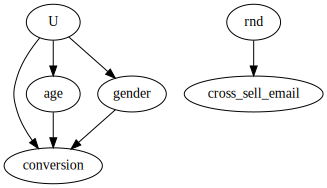

In [10]:
g_cross_sell = gr.Digraph()
g_cross_sell.edge('U', 'conversion')
g_cross_sell.edge('U', 'age')
g_cross_sell.edge('U', 'gender')
g_cross_sell.edge('rnd', 'cross_sell_email')
g_cross_sell.edge('age', 'conversion')
g_cross_sell.edge('gender', 'conversion')

g_cross_sell

# Chapter 5

In [11]:
import statsmodels.formula.api as smf

In [14]:
df = pd.read_csv('./data/management_training.csv')
print(df.shape)
df.head()

(10391, 10)


,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


In [15]:
smf.ols('engagement_score ~ intervention', 
        data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [17]:
model = smf.ols("""engagement_score ~ intervention
+ tenure + last_engagement_score + department_score 
+ n_of_reports + C(gender) + C(role)""", data=df).fit()

print("ATE:", model.params["intervention"])
print("95% CI:", model.conf_int().loc["intervention", :].values.T)

ATE: 0.2677908576676864
95% CI: [0.23357751 0.30200421]


In [19]:
ps_model = smf.logit("""intervention ~
tenure + last_engagement_score + department_score 
+ C(n_of_reports) + C(gender) + C(role)""", data=df).fit(disp=0)

In [20]:
data_ps = df.assign(
    propensity_score = ps_model.predict(df), 
)

data_ps[['intervention', 'engagement_score', 'propensity_score']].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


In [21]:
model = smf.ols('engagement_score ~ intervention + propensity_score', 
                data=data_ps).fit()

model.params['intervention']

0.2633126749027728

In [23]:
from sklearn.neighbors import KNeighborsRegressor

In [24]:
T = 'intervention'
X = 'propensity_score'
Y = 'engagement_score'

treated = data_ps.query(f'{T} == 1')
untreated = data_ps.query(f'{T} == 0')

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]], 
                                             untreated[Y])

mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[[X]])), 
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[[X]]))
])

predicted.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,propensity_score,match
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,0.596106,0.557680
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,0.391138,-0.952622
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,0.602578,-0.618381
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,0.580990,-1.404962
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,0.619976,0.000354


In [25]:
np.mean((predicted[Y] - predicted['match'])*predicted[T]
        + (predicted['match'] - predicted[Y])*(1-predicted[T]))

0.28777443474045966

In [26]:
weight_t = 1/data_ps.query('intervention==1')['propensity_score']
weight_nt = 1/(1-data_ps.query('intervention==0')['propensity_score'])
t1 = data_ps.query('intervention==1')['engagement_score']
t0 = data_ps.query('intervention==0')['engagement_score']

y1 = sum(t1*weight_t)/len(data_ps)
y0 = sum(t0*weight_nt)/len(data_ps)

print('E[Y1]:', y1)
print('E[Y0]:', y0)
print('ATE', y1 - y0)

E[Y1]: 0.11656317232946957
E[Y0]: -0.1494155364781463
ATE 0.26597870880761587


In [27]:
np.mean(data_ps['engagement_score']
        * (data_ps['intervention'] - data_ps['propensity_score'])
        / (data_ps['propensity_score']*(1-data_ps['propensity_score'])))

0.2659787088076159

In [28]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix

In [32]:
def est_ate_with_ps(df, ps_formula, T, Y):
    
    X = dmatrix(ps_formula, df)
    ps_model = LogisticRegression(penalty=None, 
                                  max_iter=1000).fit(X, df[T])
    ps = ps_model.predict_proba(X)[:, 1]
    
    return np.mean((df[T]-ps) / (ps*(1-ps)) * df[Y])

In [33]:
formula = """tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)"""
T = 'intervention'
Y = 'engagement_score'

est_ate_with_ps(df, formula, T, Y)

0.26590350294777787

In [34]:
from joblib import Parallel, delayed

In [35]:
def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]): 
    
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )
    
    return np.percentile(stats, pcts)

In [36]:
from toolz import partial

In [38]:
print(f'AET: {est_ate_with_ps(df, formula, T, Y)}')
est_fn = partial(est_ate_with_ps, ps_formula=formula, T=T, Y=Y)
print(f"95% C.I.: ", bootstrap(df, est_fn))

AET: 0.26590350294777787
95% C.I.:  [0.2265241  0.30068859]


# Chapter 6

In [43]:
data = pd.read_csv('./data/daily_restaurant_sales.csv')
data.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [44]:
import statsmodels.formula.api as smf

In [92]:
X = ['C(month)', 'C(weekday)', 'is_holiday', 'competitors_price']
regr_cate = smf.ols(f"sales ~ discounts*({'+'.join(X)})", 
                    data=data).fit()

In [47]:
ols_cate_pred = (
    regr_cate.predict(data.assign(discounts=data['discounts']+1))
    -regr_cate.predict(data)
)

In [51]:
train = data.query("day < '2018-01-01'")
test = data.query("day >= '2018-01-01'")

In [62]:
X = ['C(month)', 'C(weekday)', 'is_holiday', 'competitors_price']
regr_model = smf.ols(f"sales ~ discounts*({'+'.join(X)})", 
                    data=train).fit()

In [63]:
cate_pred = (
    regr_model.predict(test.assign(discounts=test['discounts']+1)) 
    -regr_model.predict(test)
)

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

X = ['month', 'weekday', 'is_holiday', 'competitors_price', 'discounts']
y = 'sales'

np.random.seed(1)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X], 
                                                          train[y])

ml_pred = ml_model.predict(test[X])

In [66]:
np.random.seed(123)

test_pred = test.assign(
    ml_pred=ml_pred, 
    cate_pred=cate_pred, 
    rand_m_pred=np.random.uniform(-1, 1, len(test)),
)

In [67]:
test_pred.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938


In [68]:
from toolz import curry

In [69]:
@curry
def effect(data, y, t):
    return (np.sum((data[t] - data[t].mean())*data[y]) / 
            np.sum((data[t] - data[t].mean())**2))

In [70]:
effect(test, 'sales', 'discounts')

32.16196368039615

In [71]:
def effect_by_quantile(df, pred, y, t, q=10):
    
    # makes quantile partitions
    groups = np.round(pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid, 2)
    
    return (df.assign(**{f"{pred}_quantile": groups})
            .groupby(f"{pred}_quantile")
            # estimate the effect on each quantile
            .apply(effect(y=y, t=t)))

effect_by_quantile(test_pred, "cate_pred", y="sales", t="discounts")

cate_pred_quantile
17.50    20.494153
23.93    24.782101
26.85    27.494156
28.95    28.833993
30.81    29.604257
32.68    32.216500
34.65    35.889459
36.75    36.846889
39.40    39.125449
47.36    44.272549
dtype: float64

In [81]:
effect_by_quantile(test_pred, "ml_pred", y="sales", t="discounts")

/var/folders/n5/l154bmdj3f9bn5yn6bqvqbv00000gn/T/ipykernel_89703/1313613124.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*data[y]) /


ml_pred_quantile
27.92            NaN
57.43            NaN
124.24     16.612225
198.58           NaN
262.57     -1.887918
347.80      1.100427
441.86     -3.167010
558.10     -5.932880
732.89      2.386581
1206.68    23.125698
dtype: float64

In [82]:
effect_by_quantile(test_pred, "rand_m_pred", y="sales", t="discounts")

rand_m_pred_quantile
-0.91    31.731195
-0.71    31.372904
-0.51    31.001395
-0.32    31.603589
-0.12    34.997244
 0.10    31.698705
 0.30    32.433898
 0.51    32.657934
 0.71    32.127571
 0.90    31.925685
dtype: float64

In [85]:
def cumulative_effect_curve(dataset, prediction, y, t, 
                            ascending=False, steps=100):
    size = len(dataset)
    ordered_df = (dataset
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    steps = np.linspace(size/steps, size, steps).round(0)
    
    return np.array([effect(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in steps])

cumulative_effect_curve(test_pred, "cate_pred", "sales", "discounts")

array([49.65116279, 49.37712454, 46.20360341, 45.9770684 , 45.31711812,
       45.23107566, 44.91075165, 44.74166167, 44.56309576, 44.27254859,
       43.95937553, 43.66601716, 43.30710192, 42.71556602, 42.57717619,
       42.14190207, 41.9120469 , 41.73012555, 41.59626585, 41.38073714,
       41.11778111, 41.04864418, 40.95933655, 40.6949357 , 40.5585599 ,
       40.32182723, 40.19431251, 40.02119492, 39.92014581, 39.58537488,
       39.44592589, 39.53382731, 39.41985355, 39.29287716, 39.27763551,
       39.14056914, 39.04402217, 38.98421346, 38.9022713 , 38.71601845,
       38.72423427, 38.53676256, 38.56709164, 38.36661748, 38.27685106,
       38.06110588, 37.99479087, 37.89750017, 37.72699021, 37.55580363,
       37.35825912, 37.28006651, 37.21139791, 37.06210857, 37.00753334,
       36.87259686, 36.74299254, 36.52014459, 36.4873419 , 36.38463167,
       36.21632077, 36.10908232, 35.90865968, 35.73915746, 35.56123101,
       35.42248759, 35.37393053, 35.25994908, 35.24501879, 35.14

In [88]:
def cumulative_gain_curve(df, prediction, y, t, 
                         ascending=False, normalize=False, steps=100): 
    
    effect_fn = effect(t=t, y=y)
    normalizer = effect_fn(df) if normalize else 0
    
    size = len(df)
    ordered_df = (df.
                  sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size/steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f'index <= {row}'))
               -normalizer)*(row/size)
              for row in steps]
    
    return np.array([0] + effects)

cumulative_gain_curve(test_pred, 'cate_pred', 'sales', 'discounts')

array([ 0.        ,  0.50387597,  0.982917  ,  1.38863289,  1.83046877,
        2.26408709,  2.71880783,  3.13779256,  3.58003148,  4.01798404,
        4.42379877,  4.83861979,  5.23242282,  5.62890903,  5.98551452,
        6.38159081,  6.74402024,  7.13257317,  7.5088165 ,  7.9068624 ,
        8.26968674,  8.63441305,  9.03646968,  9.41649072,  9.76869065,
       10.13172457, 10.48178647, 10.85654343, 11.20031099, 11.57715392,
       11.88179285, 12.22484979, 12.65329367, 13.00147394, 13.35835129,
       13.75177168, 14.08571614, 14.44720258, 14.8206963 , 15.16915263,
       15.48942971, 15.87058782, 16.18483861, 16.5889676 , 16.87711862,
       17.226077  , 17.51523959, 17.85547549, 18.1943502 , 18.48062947,
       18.77790182, 19.05825319, 19.38214231, 19.7240743 , 20.00659491,
       20.35269886, 20.65268403, 20.93862963, 21.18225404, 21.53351325,
       21.82793867, 22.09450014, 22.38142964, 22.62161465, 22.87752468,
       23.11063608, 23.3799479 , 23.70688475, 23.97456335, 24.32

# Chapter 7

## T-Learner

In [4]:
import pandas as pd
import numpy as np

data_biased = pd.read_csv('./data/email_obs_data.csv')
data_rnd = pd.read_csv('./data/email_rnd_data.csv')

print(len(data_biased), len(data_rnd))
data_rnd.head()

300000 10000


,mkt_email,next_mnth_pv,age,tenure,ammount_spent,vehicle,food,beverage,art,baby,...,electronics,sports,tools,games,industry,pc,jewel,books,music_books_movies,health
0,0,244.26,61.0,1.0,21.84,0,2,2,0,2,...,1,0,0,3,1,0,1,0,0,2
1,0,29.67,36.0,1.0,107.40,0,2,0,2,0,...,1,1,1,2,1,2,1,0,2,2
2,0,11.73,64.0,0.0,59.81,0,1,0,0,0,...,2,0,0,3,0,1,0,1,0,1
3,0,41.41,74.0,0.0,62.98,0,1,0,0,3,...,1,0,2,2,1,1,0,4,1,0
4,0,447.89,59.0,0.0,72.56,0,1,1,3,2,...,5,0,0,1,0,0,1,1,2,1


In [5]:
y = 'next_mnth_pv'
T = 'mkt_email'
X = list(data_rnd.drop(columns=[y, T]).columns)

train, test = data_biased, data_rnd

In [6]:
from lightgbm import LGBMRegressor

np.random.seed(123)

m0 = LGBMRegressor()
m1 = LGBMRegressor()

m0.fit(train.query(f'{T}==0')[X], train.query(f'{T}==0')[y])
m1.fit(train.query(f'{T}==1')[X], train.query(f'{T}==1')[y])

LGBMRegressor()

In [7]:
t_learner_cate_test = test.assign(
    cate=m1.predict(test[X]) - m0.predict(test[X])
)

In [11]:
t_learner_cate_test.head()

,mkt_email,next_mnth_pv,age,tenure,ammount_spent,vehicle,food,beverage,art,baby,...,sports,tools,games,industry,pc,jewel,books,music_books_movies,health,cate
0,0,244.26,61.0,1.0,21.84,0,2,2,0,2,...,0,0,3,1,0,1,0,0,2,1225.565946
1,0,29.67,36.0,1.0,107.40,0,2,0,2,0,...,1,1,2,1,2,1,0,2,2,1324.435102
2,0,11.73,64.0,0.0,59.81,0,1,0,0,0,...,0,0,3,0,1,0,1,0,1,833.561232
3,0,41.41,74.0,0.0,62.98,0,1,0,0,3,...,0,2,2,1,1,0,4,1,0,1252.194708
4,0,447.89,59.0,0.0,72.56,0,1,1,3,2,...,0,0,1,0,0,1,1,2,1,1295.510052


## X-Learner

In [12]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

In [13]:
# propensity score model
ps_model = LogisticRegression(penalty=None)
ps_model.fit(train[X], train[T])

# first stage models
train_t0 = train.query(f'{T}==0')
train_t1 = train.query(f'{T}==1')

m0 = LGBMRegressor()
m1 = LGBMRegressor()

np.random.seed(123)

m0.fit(train_t0[X], train_t0[y], 
       sample_weight=1/ps_model.predict_proba(train_t0[X])[:, 0])
m1.fit(train_t1[X], train_t1[y], 
       sample_weight=1/ps_model.predict_proba(train_t1[X])[:, 1])

LGBMRegressor()

In [14]:
tau_hat_0 = m1.predict(train_t0[X]) - train_t0[y]
tau_hat_1 = train_t1[y] - m0.predict(train_t1[X])

m_tau_0 = LGBMRegressor()
m_tau_1 = LGBMRegressor()

np.random.seed(123)

m_tau_0.fit(train_t0[X], tau_hat_0)
m_tau_1.fit(train_t1[X], tau_hat_1)

LGBMRegressor()

In [15]:
# estimate the CATE

ps_test = ps_model.predict_proba(test[X])[:, 1]

x_cate_test = test.assign(
    cate=(ps_test*m_tau_0.predict(test[X]) + 
          (1-ps_test)*m_tau_1.predict(test[X])
         )
)

In [16]:
x_cate_test.head()

,mkt_email,next_mnth_pv,age,tenure,ammount_spent,vehicle,food,beverage,art,baby,...,sports,tools,games,industry,pc,jewel,books,music_books_movies,health,cate
0,0,244.26,61.0,1.0,21.84,0,2,2,0,2,...,0,0,3,1,0,1,0,0,2,1208.513642
1,0,29.67,36.0,1.0,107.40,0,2,0,2,0,...,1,1,2,1,2,1,0,2,2,1312.263090
2,0,11.73,64.0,0.0,59.81,0,1,0,0,0,...,0,0,3,0,1,0,1,0,1,842.776186
3,0,41.41,74.0,0.0,62.98,0,1,0,0,3,...,0,2,2,1,1,0,4,1,0,1316.253693
4,0,447.89,59.0,0.0,72.56,0,1,1,3,2,...,0,0,1,0,0,1,1,2,1,1303.529794


## S-Learner

In [24]:
data_cont = pd.read_csv('./data/discount_data.csv')
data_cont.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [25]:
train = data_cont.query("day<'2018-01-01'")
test = data_cont.query("day>='2018-01-01'")

In [26]:
X = ['month', 'weekday', 'is_holiday', 'competitors_price']
T = ['discounts']
y = 'sales'

In [27]:
np.random.seed(123)
s_learner = LGBMRegressor()
s_learner.fit(train[X+T], train[y])

LGBMRegressor()

In [31]:
t_grid = pd.DataFrame(dict(key=1, 
                           discounts=np.array([0, 10, 20, 30, 40])))
test_cf = (test
           .drop(columns=['discounts'])
           .assign(key=1)
           .merge(t_grid)
           .assign(sales_hat = lambda d: s_learner.predict(d[X+T])))

test_cf

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,sales,key,discounts,sales_hat
0,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,0,67.957972
1,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,10,444.245941
2,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,20,793.045769
3,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,30,1279.640793
4,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,40,1512.630767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,6,2019-01-01,1,1,False,True,False,False,9.41,408.0,1,0,60.284810
12806,6,2019-01-01,1,1,False,True,False,False,9.41,408.0,1,10,308.358375
12807,6,2019-01-01,1,1,False,True,False,False,9.41,408.0,1,20,504.886126
12808,6,2019-01-01,1,1,False,True,False,False,9.41,408.0,1,30,798.742001


In [40]:
from toolz import curry

@curry
def linear_effect(df, y, t):
    return np.cov(df[y], df[t])[0, 1] / df[t].var()

cate = (test_cf
        .groupby(['rest_id', 'day'])
        .apply(linear_effect(t='discounts', y='sales_hat'))
        .rename('cate'))

test_s_learner_pred = test.set_index(['rest_id', 'day']).join(cate)

test_s_learner_pred.head()

month  weekday  weekend  is_holiday  is_dec  is_nov  \
rest_id day                                                               
0       2018-01-01      1        0    False        True   False   False   
        2018-01-02      1        1    False       False   False   False   
        2018-01-03      1        2    False       False   False   False   
        2018-01-04      1        3    False       False   False   False   
        2018-01-05      1        4    False       False   False   False   

                    competitors_price  discounts  sales       cate  
rest_id day                                                         
0       2018-01-01               4.92          5  251.5  37.247404  
        2018-01-02               3.06         10  541.0  40.269854  
        2018-01-03               4.61         10  431.0  37.412988  
        2018-01-04               4.84         20  760.0  38.436815  
        2018-01-05               6.29          0   78.0  31.428603

## R-Learner

In [41]:
from sklearn.model_selection import cross_val_predict

In [42]:
X = ['month', 'weekday', 'is_holiday', 'competitors_price']
T = 'discounts'
y = 'sales'

In [43]:
debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()

t_res = train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5)
y_res = train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5)

In [44]:
import statsmodels.api as sm

sm.OLS(y_res, t_res).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
discounts,31.4615,0.151,208.990,0.000,31.166,31.757


# Chapter 8

In [1]:
import pandas as pd
import numpy as np

In [2]:
mkt_data = (pd.read_csv('./data/short_offline_mkt_south.csv')
            .astype({'date': 'datetime64[ns]'}))

mkt_data.head()

,date,city,region,treated,tau,downloads,post
0,2021-05-01,5,S,0,0.0,51.0,0
1,2021-05-02,5,S,0,0.0,51.0,0
2,2021-05-03,5,S,0,0.0,51.0,0
3,2021-05-04,5,S,0,0.0,50.0,0
4,2021-05-05,5,S,0,0.0,49.0,0


In [29]:
did_data = (mkt_data
            .groupby(['treated', 'post'])
            .agg({'downloads': 'mean', 'date': 'min'}))
did_data

downloads       date
treated post                      
0       0     50.335034 2021-05-01
        1     50.556878 2021-05-15
1       0     50.944444 2021-05-01
        1     51.858025 2021-05-15

$$E[Y(0)|D=1, Post=1] = E[Y|D=1, Post=1]+(E[Y|D=0, Post=1] - E[Y|D=0, Post=0])$$

$$ATT = (E[Y(0)|D=1, Post=1] - E[Y|D=1, Post=1])-(E[Y|D=0, Post=1] - E[Y|D=0, Post=0])$$

In [35]:
y0_est = (did_data.loc[1].loc[0, 'downloads'] # treated baseline
          # control evolution
          + did_data.loc[0].diff().loc[1, 'downloads'])

In [36]:
att = did_data.loc[1].loc[1, 'downloads'] - y0_est
att

0.6917359536407233